In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm

In [2]:
rul = pd.read_csv("data/RUL_FD001.txt", header=None).values.reshape(-1)
df_train = pd.read_csv("data/train_FD001.txt", sep=' ', header=None)
df_train = df_train.drop(df_train.columns[-2:], axis=1)
df_test = pd.read_csv("data/test_FD001.txt", sep=' ', header=None)
df_test = df_test.drop(df_test.columns[-2:], axis=1)

In [3]:
column_selected = df_train[df_train.iloc[:, 0] == 1].std() > 1e-10
column_selected[0:5] = True

In [4]:
df_train = df_train.loc[:, column_selected]
df_test = df_test.loc[:, column_selected]

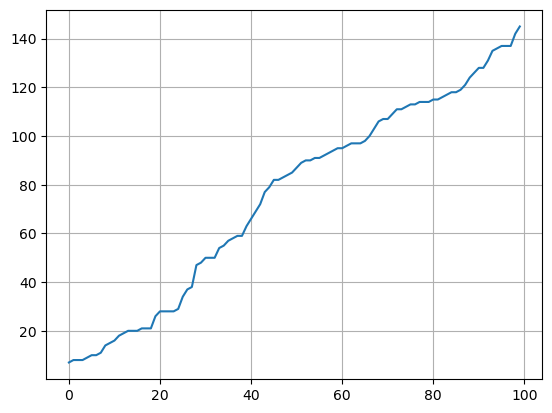

In [5]:
plt.plot(np.sort(rul))
plt.grid()

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data_train = scaler.fit_transform(df_train.iloc[:, 5:])
data_test = scaler.fit_transform(df_test.iloc[:, 5:])

In [7]:
window_size = 30
y_cap = 130
train_X = []
train_no = []
train_label = []

for i in range(1, 101):
    data_unit = data_train[df_train.iloc[:, 0] == i]
    train_X_unit = []
    train_no_unit = []

    for j in range(window_size-1):
        X_pad = np.zeros([window_size, data_unit.shape[-1]])
        X_pad[-j-1:, :] = data_unit[:j+1, :]
        train_X_unit.append(X_pad)
        train_no_unit.append(i)

    for j in range(len(data_unit)-window_size+1):
        train_X_unit.append(data_unit[j:j+window_size, :])
        train_no_unit.append(i)

    rul_unit = len(data_unit)
    y_unit = np.arange(rul_unit, 0, -1) - 1
    y_unit[y_unit>y_cap] = y_cap

    train_X += train_X_unit[:rul_unit]
    train_no += train_no_unit[:rul_unit]

    train_label += list(y_unit)

    #print((i, len(train_label), len(train_X), rul_unit, len(data_unit)))

train_X = torch.tensor(np.array(train_X), dtype=torch.float32)
train_label = torch.tensor(np.array(train_label), dtype=torch.float32)
train_no = torch.tensor(np.array(train_no), dtype=torch.int32)

In [8]:
test_X = []
test_label = []
test_no = []

for i in range(1, 101):
    data_unit = data_test[df_test.iloc[:, 0] == i]
    test_X_unit = []
    test_no_unit = []

    for j in range(window_size-1):
        X_pad = np.zeros([window_size, data_unit.shape[-1]])
        X_pad[-j-1:, :] = data_unit[:j+1, :]
        test_X_unit.append(X_pad)
        test_no_unit.append(i)

    for j in range(len(data_unit)-window_size+1):
        test_X_unit.append(data_unit[j:j+window_size, :])
        test_no_unit.append(i)

    rul_unit = rul[i-1]
    y_unit = np.arange(rul_unit, rul_unit - len(data_unit), -1) - 1
    y_unit[y_unit>y_cap] = y_cap
    y_unit[y_unit<0.] = 0.
    
    if len(test_X_unit) != len(y_unit):
        print((len(test_X_unit), len(y_unit)))

    test_X += test_X_unit
    test_no += test_no_unit
    test_label += list(y_unit)

test_X = torch.tensor(np.array(test_X), dtype=torch.float32)
test_label = torch.tensor(np.array(test_label), dtype=torch.float32)
test_no = torch.tensor(np.array(test_no), dtype=torch.int32)

In [9]:
# Normalize label
# train_label = train_label / y_cap
# test_label = test_label / y_cap

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.act = nn.Tanh()
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        final_out = lstm_out[:, -1, :]
        final_out = self.act(final_out)
        output = self.fc(final_out)
        return output.reshape(-1)

In [11]:
input_dim = 14
hidden_dim = 128
output_dim = 1
model = LSTM(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
batch_size = 64

train_dataset = TensorDataset(train_X, train_label)
test_dataset = TensorDataset(test_X, test_label)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    for i, (inputs, labels) in enumerate(train_loader):
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0 and (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("训练结束")

 18%|█▊        | 9/50 [11:04<52:54, 77.43s/it]

Epoch [10/50], Step [100/323], Loss: 1803.4569
Epoch [10/50], Step [200/323], Loss: 1923.0625
Epoch [10/50], Step [300/323], Loss: 1663.5366


 38%|███▊      | 19/50 [16:31<07:59, 15.47s/it]

Epoch [20/50], Step [100/323], Loss: 170.4284
Epoch [20/50], Step [200/323], Loss: 188.4754
Epoch [20/50], Step [300/323], Loss: 110.1012


 58%|█████▊    | 29/50 [18:10<03:42, 10.57s/it]

Epoch [30/50], Step [100/323], Loss: 113.3177
Epoch [30/50], Step [200/323], Loss: 162.4833
Epoch [30/50], Step [300/323], Loss: 120.5997


 78%|███████▊  | 39/50 [19:21<01:11,  6.46s/it]

Epoch [40/50], Step [100/323], Loss: 163.3044
Epoch [40/50], Step [200/323], Loss: 174.3207
Epoch [40/50], Step [300/323], Loss: 126.0620


 98%|█████████▊| 49/50 [20:24<00:06,  6.11s/it]

Epoch [50/50], Step [100/323], Loss: 137.7061
Epoch [50/50], Step [200/323], Loss: 155.4644
Epoch [50/50], Step [300/323], Loss: 66.3883


100%|██████████| 50/50 [20:30<00:00, 24.61s/it]

训练结束


In [16]:
num_epochs = 150
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    for i, (inputs, labels) in enumerate(train_loader):
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0 and (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("训练结束")

  2%|▏         | 9/450 [00:59<45:56,  6.25s/it]  

Epoch [10/450], Step [100/323], Loss: 85.3734
Epoch [10/450], Step [200/323], Loss: 105.5949
Epoch [10/450], Step [300/323], Loss: 78.9764


  4%|▍         | 19/450 [02:00<44:01,  6.13s/it]

Epoch [20/450], Step [100/323], Loss: 49.5805
Epoch [20/450], Step [200/323], Loss: 55.7804
Epoch [20/450], Step [300/323], Loss: 89.5788


  6%|▋         | 29/450 [03:02<43:15,  6.17s/it]

Epoch [30/450], Step [100/323], Loss: 15.6054
Epoch [30/450], Step [200/323], Loss: 30.7928
Epoch [30/450], Step [300/323], Loss: 28.5895


  9%|▊         | 39/450 [04:03<42:54,  6.26s/it]

Epoch [40/450], Step [100/323], Loss: 24.6868
Epoch [40/450], Step [200/323], Loss: 37.1640
Epoch [40/450], Step [300/323], Loss: 27.7742


 11%|█         | 49/450 [05:05<41:29,  6.21s/it]

Epoch [50/450], Step [100/323], Loss: 9.9974
Epoch [50/450], Step [200/323], Loss: 13.7153
Epoch [50/450], Step [300/323], Loss: 16.9729


 13%|█▎        | 59/450 [06:08<40:55,  6.28s/it]

Epoch [60/450], Step [100/323], Loss: 11.2058
Epoch [60/450], Step [200/323], Loss: 6.1381
Epoch [60/450], Step [300/323], Loss: 5.9153


 15%|█▌        | 69/450 [07:09<39:07,  6.16s/it]

Epoch [70/450], Step [100/323], Loss: 10.6319
Epoch [70/450], Step [200/323], Loss: 7.3650
Epoch [70/450], Step [300/323], Loss: 6.8575


 18%|█▊        | 79/450 [08:11<38:12,  6.18s/it]

Epoch [80/450], Step [100/323], Loss: 2.6375
Epoch [80/450], Step [200/323], Loss: 3.0687
Epoch [80/450], Step [300/323], Loss: 3.8281


 20%|█▉        | 89/450 [09:13<37:22,  6.21s/it]

Epoch [90/450], Step [100/323], Loss: 4.1236
Epoch [90/450], Step [200/323], Loss: 2.3050
Epoch [90/450], Step [300/323], Loss: 3.9994


 22%|██▏       | 99/450 [10:15<36:47,  6.29s/it]

Epoch [100/450], Step [100/323], Loss: 2.8391
Epoch [100/450], Step [200/323], Loss: 5.6225
Epoch [100/450], Step [300/323], Loss: 10.2141


 24%|██▍       | 109/450 [11:18<35:38,  6.27s/it]

Epoch [110/450], Step [100/323], Loss: 1.6772
Epoch [110/450], Step [200/323], Loss: 1.7695
Epoch [110/450], Step [300/323], Loss: 1.4050


 26%|██▋       | 119/450 [12:22<35:16,  6.39s/it]

Epoch [120/450], Step [100/323], Loss: 16.7973
Epoch [120/450], Step [200/323], Loss: 2.3215
Epoch [120/450], Step [300/323], Loss: 3.5433


 29%|██▊       | 129/450 [13:26<33:27,  6.25s/it]

Epoch [130/450], Step [100/323], Loss: 0.6274
Epoch [130/450], Step [200/323], Loss: 0.5567
Epoch [130/450], Step [300/323], Loss: 0.6218


 30%|███       | 136/450 [14:11<32:46,  6.26s/it]


KeyboardInterrupt: 

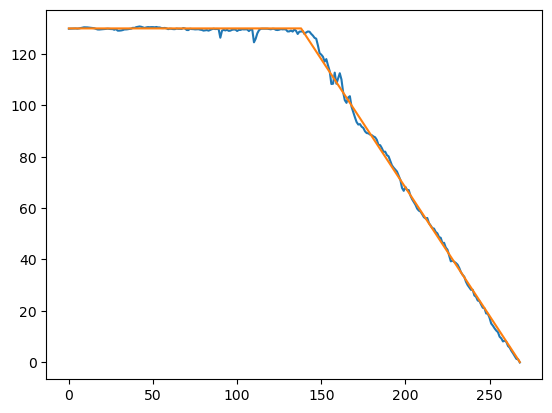

In [17]:
model.eval()
pred = model(train_X[train_no==5]).detach().numpy()
plt.plot(pred)
plt.plot(train_label[train_no==5])

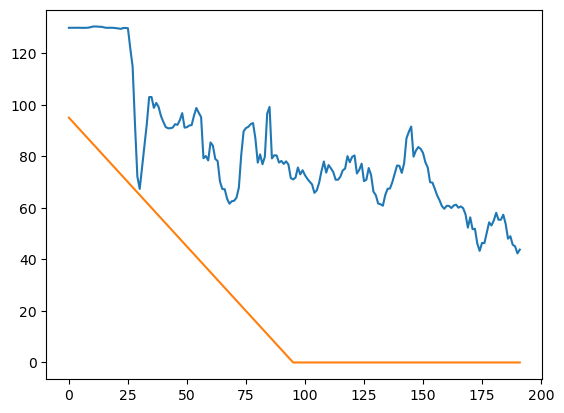

In [20]:
model.eval()
pred = model(test_X[test_no==10]).detach().numpy()
plt.plot(pred)
plt.plot(test_label[test_no==10])